# Dataset Statictsics

## Import Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from PIL import Image
import matplotlib.font_manager

## Implementation of Some Necessary functions

In [37]:
# Set the font to Arial and font size globally
matplotlib.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 12

SETTING = "ZSL"
RANDOM_SEED = 12345

# phosphorylation datasets
train_dataset_file = f'datasets/random_seed_{RANDOM_SEED}/{SETTING}/train_data_random_seed_{RANDOM_SEED}.csv'
validation_dataset_file = f'datasets/random_seed_{RANDOM_SEED}/{SETTING}/{SETTING}_validation_data_random_seed_{RANDOM_SEED}.csv'
test_dataset_file = f'datasets/random_seed_{RANDOM_SEED}/{SETTING}/{SETTING}_test_data_random_seed_{RANDOM_SEED}.csv'

# kinase datasts
train_kinases_file = f'datasets/random_seed_{RANDOM_SEED}/{SETTING}/train_kinases_random_seed_{RANDOM_SEED}.csv'
validation_kinases_file = f'datasets/random_seed_{RANDOM_SEED}/{SETTING}/{SETTING}_validation_kinases_random_seed_{RANDOM_SEED}.csv'
test_kinases_file = f'datasets/random_seed_{RANDOM_SEED}/{SETTING}/{SETTING}_test_kinases_random_seed_{RANDOM_SEED}.csv'

dataset_statistics_directory = f'dataset_statistics'

CURATED_KINASE_DATASET_FILE = "data_files/Curated_557_kinase_dataset.csv"
CLEAN_KINASE_SUBSTRATE_DATASET = "data_files/Clean_Kinase_Substrate_Dataset.csv"


def create_thresholds(start, end, incr):
    return [i for i in range(start+incr, end+1, incr)]

def get_train_kinases():
    df = pd.read_csv(train_kinases_file)
    kinases = set(df["Kinase"].unique())
    return kinases

def map_family_group_info():
    file = CURATED_KINASE_DATASET_FILE
    df = pd.read_csv(file)

    uniprots_to_family = {}
    uniprots_to_group = {}
    for index, row in df.iterrows():
        uniprotID = row["Entry"]
        family = row["Family"] if not pd.isna(row["Family"]) else "missing family"
        group = row["Group"] if not pd.isna(row["Group"]) else "missing group"

        if family != "missing family":
            uniprots_to_family[uniprotID] = family
        if group != "missing group":
            uniprots_to_group[uniprotID] = group
    return uniprots_to_family, uniprots_to_group

def get_validation_kinases():
    df = pd.read_csv(validation_kinases_file)
    kinases = set(df["Kinase"].unique())
    return kinases

def get_test_kinases():
    df = pd.read_csv(test_kinases_file)
    kinases = set(df["Kinase"].unique())
    return kinases

def get_train_sites_to_kinases():
    train_rows = get_train_rows()

    site_to_kinases_that_have_been_trained_on = dict()
    for row in train_rows:
        site_identifier = f'{row["SUB_ACC_ID"]}|{row["SUB_MOD_RSD"]}|{row["SITE_+/-7_AA"]}'
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        site_to_kinases_that_have_been_trained_on[site_identifier] = kinases

    return site_to_kinases_that_have_been_trained_on

def get_validation_sites_to_kinases():
    validation_rows = get_validation_rows()

    validation_sites_to_kinases = dict()
    for row in validation_rows:
        site_identifier = f'{row["SUB_ACC_ID"]}|{row["SUB_MOD_RSD"]}|{row["SITE_+/-7_AA"]}'
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        validation_sites_to_kinases[site_identifier] = kinases

    return validation_sites_to_kinases

def get_test_sites_to_kinases():
    test_rows = get_test_rows()

    test_sites_to_kinases = dict()
    for row in test_rows:
        site_identifier = f'{row["SUB_ACC_ID"]}|{row["SUB_MOD_RSD"]}|{row["SITE_+/-7_AA"]}'
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        test_sites_to_kinases[site_identifier] = kinases

    return test_sites_to_kinases

def get_train_rows():
    all_acceptable_kinases = get_train_kinases()

    train_rows = dict()
    df = pd.read_csv(train_dataset_file)
    for index, row in df.iterrows():
        site_identifier = f'{row["SUB_ACC_ID"]}|{row["SUB_MOD_RSD"]}|{row["SITE_+/-7_AA"]}'

        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        kinases = kinases.intersection(all_acceptable_kinases)
        kinases = list(kinases)
        kinases.sort()
        new_row = row.copy()
        new_row['KINASE_ACC_IDS'] = ",".join(kinases)

        train_rows[site_identifier] = new_row

    train_rows = list(train_rows.values())

    return train_rows

def get_validation_rows():
    train_sites_to_kinases = get_train_sites_to_kinases()
    all_acceptable_kinases = get_validation_kinases()

    valid_rows = dict()
    df = pd.read_csv(validation_dataset_file)
    for index, row in df.iterrows():
        site_identifier = f'{row["SUB_ACC_ID"]}|{row["SUB_MOD_RSD"]}|{row["SITE_+/-7_AA"]}'
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        kinases = kinases.intersection(all_acceptable_kinases)
        new_row = row.copy()
        if site_identifier in train_sites_to_kinases:
            # this means this site is also in train, so only count the kinases which have not been trained on
            # as the test data
            already_trained_kinases = set(train_sites_to_kinases[site_identifier])
            remove_already_trained_kinases = list(kinases - already_trained_kinases)
            remove_already_trained_kinases.sort()
            new_row['KINASE_ACC_IDS'] = ",".join(remove_already_trained_kinases)
            valid_rows[site_identifier] = new_row
        else:
            kinases = list(kinases)
            kinases.sort()
            new_row['KINASE_ACC_IDS'] = ",".join(kinases)
            valid_rows[site_identifier] = new_row

    valid_rows = list(valid_rows.values())

    return valid_rows

def get_test_rows():
    # here since the test rows is going to be the test data, the train will be the train-valid merged one
    train_sites_to_kinases = get_train_sites_to_kinases()
    validation_sites_to_kinases = get_validation_sites_to_kinases()
    train_and_validation_sites_to_kinases_merged = merge_train_and_validation_sites_to_kinases(train_sites_to_kinases, validation_sites_to_kinases)
    all_acceptable_kinases = get_test_kinases()

    # So here we need to get rid of these:
    # 1. The only train kinases. (This removed when we do only train intersection)
    # 2. We need to not count the seen kinases whose site was also seen in train. So for example:
    #    site1 --> k1(seen test), k2(unseen test) (inside train)
    #    site1 --> k1(seen test), k2(unseen test) (inside test) --> but here we chouldnt count k1 as test data because
    #                                                               it was already trained on this.


    test_rows = dict()
    df = pd.read_csv(test_dataset_file)
    for index, row in df.iterrows():
        site_identifier = f'{row["SUB_ACC_ID"]}|{row["SUB_MOD_RSD"]}|{row["SITE_+/-7_AA"]}'
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        kinases = kinases.intersection(all_acceptable_kinases)
        new_row = row.copy()
        if site_identifier in train_and_validation_sites_to_kinases_merged:
            # this means this site is also in train, so only count the kinases which have not been trained on
            # as the test data
            already_trained_kinases = set(train_and_validation_sites_to_kinases_merged[site_identifier])
            remove_already_trained_kinases = list(kinases - already_trained_kinases)
            remove_already_trained_kinases.sort()
            if len(remove_already_trained_kinases) > 0: # this shouldn't be a problem because I already had a test for this, however I still wanted to add this check
                                                        # since it makes sense to remove the row itself if there are no kinases left to test.
                new_row['KINASE_ACC_IDS'] = ",".join(remove_already_trained_kinases)
                test_rows[site_identifier] = new_row
        else:
            kinases = list(kinases)
            kinases.sort()
            new_row['KINASE_ACC_IDS'] = ",".join(kinases)
            test_rows[site_identifier] = new_row

    test_rows = list(test_rows.values())

    return test_rows

def merge_train_and_validation_sites_to_kinases(train_sites_to_kinases, validation_sites_to_kinases):
    merged_train_and_validation_rows_to_kinases = train_sites_to_kinases
    for site, validation_kinases in validation_sites_to_kinases.items():
        if site in train_sites_to_kinases:
            # then merge the kinases:
            train_kinases = set(train_sites_to_kinases[site])
            merged_kinases = list(train_kinases.union(set(validation_kinases)))
            merged_kinases.sort()
            merged_train_and_validation_rows_to_kinases[site] = merged_kinases
        else:
            merged_train_and_validation_rows_to_kinases[site] = validation_kinases
    return merged_train_and_validation_rows_to_kinases

def setup_axes(ax, bins, column_title, threshold_strings, max_y_value):
    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1
    # ax.set_xlabel("Number of phosphorylation sites", fontweight='bold')
    ax.set_ylabel("Number of kinases", fontweight='bold', fontsize=12, labelpad=20)
    ax.set_title(column_title, fontweight='bold', fontsize=12)
    # ax.set_yticks(range(0, max(bins) + 10, 10))

    # Instead of max(bins) + 10, use the provided max_y_value to set y-ticks
    ax.set_yticks(range(0, max_y_value, 10))  # Adjust the step if necessary

    y_labels = [str(i) if i % 50 == 0 else '' for i in range(0, max_y_value, 10)]
    ax.set_yticklabels(y_labels)

    # Set the upper limit for the y-axis based on the max_y_value
    ax.set_ylim(0, max_y_value+30)

    # for i, count in enumerate(bins):
    #     ax.text(i, count + 0.5, str(count), ha='center')

    # Remove the line boundaries
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.bar(threshold_strings, bins, color=grayish_color, linewidth=0.5)
    ax.set_xticks(range(len(threshold_strings)))  # This line is crucial
    ax.set_xticklabels(threshold_strings, rotation=90, fontsize=10)
    ax.set_axisbelow(True)
    ax.grid(axis='y', zorder=0)

def get_kinase_count_in_dataset():
    train_rows = get_train_rows()
    validation_rows = get_validation_rows()
    test_rows = get_test_rows()

    train_kinase_counts = dict()
    for row in train_rows:
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        for kinase in kinases:
            if kinase not in train_kinase_counts:
                train_kinase_counts[kinase] = 0
            train_kinase_counts[kinase] += 1

    validation_kinase_counts = dict()
    for row in validation_rows:
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        for kinase in kinases:
            if kinase not in validation_kinase_counts:
                validation_kinase_counts[kinase] = 0
            validation_kinase_counts[kinase] += 1

    test_kinase_counts = dict()
    for row in test_rows:
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        for kinase in kinases:
            if kinase not in test_kinase_counts:
                test_kinase_counts[kinase] = 0
            test_kinase_counts[kinase] += 1

    return train_kinase_counts, validation_kinase_counts, test_kinase_counts

def fill_in_subplots_for__get_kinase_group_distributions(axes, column, x_values_kinase_group, x_values_kinase_count_group, x_labels_kinase_group, x_labels_kinase_count_group, font_size, row_1_max, row_2_max):
    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1
    '''axes[0, column].set_axis_off()
    text = f'Total unique kinases : {sum(x_values_kinase_group)}\n' \
           f'Total row counts : {sum(x_values_kinase_count_group)}'
    axes[0, column].text(0.5, 0.5, text, ha='center', va='top')'''

    axes[0, column].bar(x_labels_kinase_group, x_values_kinase_group, color=grayish_color)
    if column == 1:
        axes[0, column].set_xlabel('Kinase Groups', fontsize=10, fontweight='bold')
    if column == 0:
        axes[0, column].set_ylabel('Unique Kinase Count', fontsize=font_size, fontweight='bold')
    axes[0, column].tick_params(axis='x', rotation=45, labelsize=font_size)
    '''for i, count in enumerate(x_values_kinase_group):
        axes[0, column].text(i, count + 0.5, str(count), ha='center')'''
    axes[0, column].set_axisbelow(True)
    axes[0, column].grid(axis='y', zorder=0)
    axes[0, column].spines['top'].set_visible(False)
    axes[0, column].spines['right'].set_visible(False)
    axes[0, column].spines['left'].set_visible(False)
    axes[0, column].tick_params(axis='both', which='both', length=0)

    axes[0, column].set_yticks(range(0, row_1_max + 1, 10))  # Adjust the step if necessary

    # Set the upper limit for the y-axis based on the max_y_value
    axes[0, column].set_ylim(0, row_1_max)

    if column != 0:
        axes[0, column].set_yticklabels([])
        axes[0, column].set_ylabel("", fontweight='bold')

    axes[1, column].bar(x_labels_kinase_count_group, x_values_kinase_count_group, color=grayish_color)
    if column == 1:
        axes[1, column].set_xlabel('Kinase Groups', fontsize=10, fontweight='bold')
    if column == 0:
        axes[1, column].set_ylabel('Phosphosite Count', fontsize=font_size, fontweight='bold')
    axes[1, column].tick_params(axis='x', rotation=45, labelsize=font_size)
    '''for i, count in enumerate(x_values_kinase_count_group):
        axes[1, column].text(i, count + 0.5, str(count), ha='center')'''
    axes[1, column].set_axisbelow(True)
    axes[1, column].grid(axis='y', zorder=0)
    axes[1, column].spines['top'].set_visible(False)
    axes[1, column].spines['right'].set_visible(False)
    axes[1, column].spines['left'].set_visible(False)
    axes[1, column].tick_params(axis='both', which='both', length=0)

    axes[1, column].set_yticks(range(0, row_2_max + 1, 300))  # Adjust the step if necessary

    # Set the upper limit for the y-axis based on the max_y_value
    axes[1, column].set_ylim(0, row_2_max)

    if column != 0:
        axes[1, column].set_yticklabels([])
        axes[1, column].set_ylabel("", fontweight='bold')

def fill_in_subplot_for__get_multilabel_rows_distribution(axes, column, train_nonmultilabel_rows, train_multilabel_rows, x_labels_site, x_values_site, dataset, font_size, max_y_value):
    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1

    axes[column].bar(x_labels_site, x_values_site, color=grayish_color)
    # axes[column].set_xlabel('', fontsize=font_size, fontweight='bold')
    if column == 0:
        axes[column].set_ylabel('Phosphosite Count', fontsize=font_size, fontweight='bold')
    else:
        axes[column].set_yticklabels([])
        axes[column].set_ylabel("", fontweight='bold')
    axes[column].tick_params(axis='x', labelsize=font_size)
    axes[column].set_axisbelow(True)
    axes[column].grid(axis='y', zorder=0)
    axes[column].spines['top'].set_visible(False)
    axes[column].spines['right'].set_visible(False)
    axes[column].spines['left'].set_visible(False)
    axes[column].tick_params(axis='both', which='both', length=0)
    axes[column].set_yticks(range(0, max_y_value + 1, 500))  # Adjust the step if necessary
    axes[column].set_ylim(0, max_y_value)

def get_site_to_kinase_count(rows):
    site_counts_in_dataset = dict()
    for row in rows:
        site_identifier = f'{row["SUB_ACC_ID"]}|{row["SUB_MOD_RSD"]}|{row["SITE_+/-7_AA"]}'
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        site_counts_in_dataset[site_identifier] = len(kinases)
    return site_counts_in_dataset

def fill_in_subplot_for__get_novel_site_vs_common_site_distribution_for_test(axes, font_size, x_labels_site, x_values_count_site, x_values_site):
    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1
    axes[0].bar(x_labels_site, x_values_site, color=grayish_color)
    # axes[0].set_xlabel('Site identifier(Common or Novel?)', fontsize=font_size, fontweight='bold')
    axes[0].set_ylabel('Phosphosite count', fontsize=font_size, fontweight='bold')
    axes[0].tick_params(axis='both', which='both', length=0)

    axes[0].tick_params(axis='x', labelsize=font_size)
    axes[0].set_axisbelow(True)
    axes[0].grid(axis='y', zorder=0)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['left'].set_visible(False)


    axes[1].bar(x_labels_site, x_values_count_site, color=grayish_color)
    # axes[1].set_xlabel('Site identifier(Common or Novel?)', fontsize=font_size, fontweight='bold')
    axes[1].set_ylabel('Phosphosite-Kinase pair count', fontsize=font_size, fontweight='bold')
    axes[1].tick_params(axis='both', which='both', length=0)
    axes[1].tick_params(axis='x', labelsize=font_size)
    axes[1].set_axisbelow(True)
    axes[1].grid(axis='y', zorder=0)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['left'].set_visible(False)

def fill_in_subplot_for__get_novel_site_vs_common_site_distribution(axes, column, font_size, x_labels_site, x_values_count_site, x_values_site):
    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1
    axes[0, column].bar(x_labels_site, x_values_site, color=grayish_color)
    if column == 1:
        axes[0, column].set_xlabel('Site identifier(Common or Novel?)', fontsize=font_size, fontweight='bold')
    if column == 0:
        axes[0, column].set_ylabel('Phosphosite count', fontsize=font_size, fontweight='bold')
        axes[0, column].tick_params(axis='both', which='both', length=0)

    axes[0, column].tick_params(axis='x', rotation=45, labelsize=font_size)
    '''for i, count in enumerate(x_values_site):
        axes[0, column].text(i, count + 0.5, str(count), ha='center')'''
    axes[0, column].set_axisbelow(True)
    axes[0, column].grid(axis='y', zorder=0)
    axes[0, column].spines['top'].set_visible(False)
    axes[0, column].spines['right'].set_visible(False)
    axes[0, column].spines['left'].set_visible(False)


    axes[1, column].bar(x_labels_site, x_values_count_site, color=grayish_color)
    if column == 1:
        axes[1, column].set_xlabel('Site identifier(Common or Novel?)', fontsize=font_size, fontweight='bold')
    if column == 0:
        axes[1, column].set_ylabel('Phosphosite-Kinase pair count', fontsize=font_size, fontweight='bold')
        axes[1, column].tick_params(axis='both', which='both', length=0)
    axes[1, column].tick_params(axis='x', rotation=45, labelsize=font_size)
    '''for i, count in enumerate(x_values_count_site):
        axes[1, column].text(i, count + 0.5, str(count), ha='center')'''
    axes[1, column].set_axisbelow(True)
    axes[1, column].grid(axis='y', zorder=0)
    axes[1, column].spines['top'].set_visible(False)
    axes[1, column].spines['right'].set_visible(False)
    axes[1, column].spines['left'].set_visible(False)

def fill_in_subplots_for__get_multilabel_rows_distribution_histogram(axes, column, x_labels_site, x_values_site, font_size, max_y_value):
    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1
    axes[column].bar(x_labels_site, x_values_site, color=grayish_color)
    if column == 1:
        axes[column].set_xlabel('Kinase Count', fontsize=font_size, fontweight='bold', labelpad=15)
    if column == 0:
        axes[column].set_ylabel('Phosphosite Count', fontsize=font_size, fontweight='bold')
    else:
        axes[column].set_yticklabels([])
        axes[column].set_ylabel("", fontweight='bold')
    axes[column].tick_params(axis='x', labelsize=font_size)
    axes[column].set_axisbelow(True)
    axes[column].grid(axis='y', zorder=0)
    axes[column].spines['top'].set_visible(False)
    axes[column].spines['right'].set_visible(False)
    axes[column].spines['left'].set_visible(False)
    axes[column].tick_params(axis='both', which='both', length=0)
    axes[column].set_yticks(range(0, max_y_value + 1, 500))  # Adjust the step if necessary
    axes[column].set_ylim(0, max_y_value)

def fill_in_subplots_for__get_kinase_group_distributions_with_site_count_information(axes, column, x_values_kinase_group, unique_sites, x_labels_kinase_group, x_labels_kinase_count_group, x_values_kinase_count_group, font_size):
    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1
    axes[0, column].set_axis_off()
    text = f'Total unique kinases : {sum(x_values_kinase_group)}\n' \
           f'Total unique site counts : {len(unique_sites)}'
    axes[0, column].text(0.5, 0.5, text, ha='center', va='top')

    axes[1, column].bar(x_labels_kinase_group, x_values_kinase_group, color=grayish_color)
    axes[1, column].set_xlabel('Kinase Groups', fontsize=font_size, fontweight='bold')
    axes[1, column].set_ylabel('Unique Site Count', fontsize=font_size, fontweight='bold')
    axes[1, column].tick_params(axis='x', rotation=45, labelsize=font_size)
    # for i, count in enumerate(x_values_kinase_group):
    #     axes[1, column].text(i, count + 0.5, str(count), ha='center')
    axes[1, column].set_axisbelow(True)
    axes[1, column].grid(axis='y', zorder=0)
    axes[1, column].spines['top'].set_visible(False)
    axes[1, column].spines['right'].set_visible(False)
    axes[1, column].spines['left'].set_visible(False)
    axes[1, column].tick_params(axis='both', which='both', length=0)

    axes[2, column].bar(x_labels_kinase_count_group, x_values_kinase_count_group, color=grayish_color)
    axes[2, column].set_xlabel('Kinase Groups', fontsize=font_size, fontweight='bold')
    axes[2, column].set_ylabel('Total data(row) count', fontsize=font_size, fontweight='bold')
    axes[2, column].tick_params(axis='x', rotation=45, labelsize=font_size)
    # for i, count in enumerate(x_values_kinase_count_group):
    #     axes[2, column].text(i, count + 0.5, str(count), ha='center')
    axes[2, column].set_axisbelow(True)
    axes[2, column].grid(axis='y', zorder=0)
    axes[2, column].spines['top'].set_visible(False)
    axes[2, column].spines['right'].set_visible(False)
    axes[2, column].spines['left'].set_visible(False)
    axes[2, column].tick_params(axis='both', which='both', length=0)

## 1. Kinase Count

This plot shows the number of kinases in each set (train, validation adn test).

### Function

In [24]:
'''
###################################################################################
### Function Description:
###
### This function plots the kinase counts in each the train-validation-test sets.
###################################################################################
'''
def get_kinase_counts_in_datasets():
    # Set the font to Arial and font size globally
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    matplotlib.rcParams['font.size'] = 12

    # since all rows have a unique site identifier, the row counts will give the site counts
    train_rows = get_train_rows()
    validation_rows = get_validation_rows()
    test_rows = get_test_rows()

    train_kinases = set()
    for row in train_rows:
        kinases_in_site = row["KINASE_ACC_IDS"]
        kinases_in_site = set(kinases_in_site.split(','))
        train_kinases = train_kinases.union(kinases_in_site)

    validation_kinases = set()
    for row in validation_rows:
        kinases_in_site = row["KINASE_ACC_IDS"]
        kinases_in_site = set(kinases_in_site.split(','))
        validation_kinases = validation_kinases.union(kinases_in_site)

    test_kinases = set()
    for row in test_rows:
        kinases_in_site = row["KINASE_ACC_IDS"]
        kinases_in_site = set(kinases_in_site.split(','))
        test_kinases = test_kinases.union(kinases_in_site)

    column_names = ["Train", "Validation", "Test"]
    kinase_counts = [len(train_kinases), len(validation_kinases), len(test_kinases)]

    # Creating the bar graph
    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1

    fig, ax = plt.subplots(figsize=(4, 6))
    bar_width = 0.01  # Set the width to your desired thinness

    # Calculate the positions for the bars to be closer together
    # The number here should be the distance between the centers of each bar
    # Adjust this as needed to bring the bars closer or further apart
    distance_between_bars = 0.15
    bar_positions = [0, distance_between_bars/10, 2*(distance_between_bars/10)]

    # Creating the bar graph with the updated positions
    bars = ax.bar(bar_positions, kinase_counts, color=grayish_color, width=bar_width)

    # Set the x-axis ticks to be the positions, and the labels to be your column names
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(column_names, rotation=90)

    # Adding horizontal grid lines and customizing spines and ticks
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.tick_params(axis='both', which='both', length=0)

    # Adding the count above each bar
    # for bar in bars:
    #     yval = bar.get_height()
    #     ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval),
    #             va='bottom', ha='center')

    # Setting labels and title
    ax.set_xlabel('Datasets', labelpad=15)
    ax.set_ylabel('Kinase Count')
    # ax.set_title('Kinase Count in Each Set')

    # Display the plot
    plt.tight_layout()  # Adjust layout
    
    plt.show()
    # If you want to save the images, comment plt.show() and uncomment the two following lines:
    # plt.savefig(f'{dataset_statistics_directory}/kinase_count_in_each_set.pdf', format='pdf', bbox_inches='tight', dpi=350)
    # plt.savefig(f'{dataset_statistics_directory}/kinase_count_in_each_set.png', format='png', bbox_inches='tight', dpi=350)

### Function Call

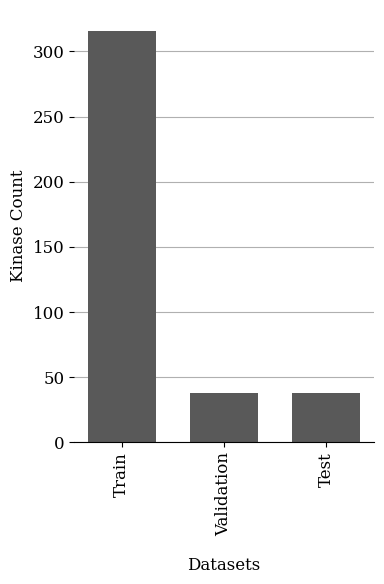

In [14]:
get_kinase_counts_in_datasets()

## 2. Phosphosite Count

This plot shows the number of phosphosites in each set (train, validation adn test). 

### Function

In [23]:
'''
###################################################################################
### Function Description:
###
### This function plots the number of sites in each the train-validation-test sets.
###################################################################################
'''
def get_sites_distribution():
    # since all rows have a unique site identifier, the row counts will give the site counts
    train_rows = get_train_rows()
    validation_rows = get_validation_rows()
    test_rows = get_test_rows()

    column_names = ["Train", "Validation", "Test"]
    site_counts = [len(train_rows), len(validation_rows), len(test_rows)]

    # Creating the bar graph
    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1

    # fig, ax = plt.subplots(figsize=(10, 6))
    # bars = ax.bar(column_names, site_counts, color=grayish_color)

    fig, ax = plt.subplots(figsize=(4, 6))
    bar_width = 0.01  # Set the width to your desired thinness

    # Calculate the positions for the bars to be closer together
    # The number here should be the distance between the centers of each bar
    # Adjust this as needed to bring the bars closer or further apart
    distance_between_bars = 0.15
    bar_positions = [0, distance_between_bars / 10, 2 * (distance_between_bars / 10)]

    # Creating the bar graph with the updated positions
    bars = ax.bar(bar_positions, site_counts, color=grayish_color, width=bar_width)

    # Set the x-axis ticks to be the positions, and the labels to be your column names
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(column_names)

    # Adding horizontal grid lines and customizing spines and ticks
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)

    # Adding the count above each bar
    # for bar in bars:
    #     yval = bar.get_height()
    #     ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval),
    #             va='bottom', ha='center')

    # Setting labels and title
    ax.set_xlabel('Datasets', labelpad=15)
    ax.set_ylabel('Number of Phosphosites')
    # ax.set_title('Site count in each Set')

    plt.tight_layout()  # Adjust layout
    # Display the plot
    plt.show()
    # If you want to save the images, comment plt.show() and uncomment the two following lines:
    # plt.savefig(f'{dataset_statistics_directory}/phosphosite_count_in_each_set.pdf', format='pdf', bbox_inches='tight', dpi=350)
    # plt.savefig(f'{dataset_statistics_directory}/phosphosite_count_in_each_set.png', format='png', bbox_inches='tight', dpi=350)  # You can increase dpi if needed


### Function Call

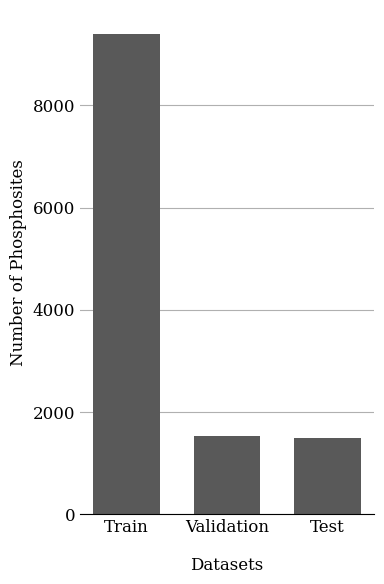

In [17]:
get_sites_distribution()

## 3. Phosphosite-Kinase Count

This plot shows the number of phosphosite-kinase association data points in each set (train, validation adn test).

### Function

In [22]:
'''
###################################################################################
### Function Description:
###
### This function plots the number of phosphosite-kinase pair associations in each the train-validation-test sets.
###################################################################################
'''
def get_phosphosite_kinase_pair_distribution():
    # Set the font to Arial and font size globally
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    matplotlib.rcParams['font.size'] = 12

    # since all rows have a unique site identifier, the row counts will give the site counts
    train_rows = get_train_rows()
    validation_rows = get_validation_rows()
    test_rows = get_test_rows()

    train_phosphosite_kinase_pair_count = 0
    for row in train_rows:
        kinases_in_site = row["KINASE_ACC_IDS"]
        kinases_in_site = set(kinases_in_site.split(','))
        train_phosphosite_kinase_pair_count += len(kinases_in_site)

    validation_phosphosite_kinase_pair_count = 0
    for row in validation_rows:
        kinases_in_site = row["KINASE_ACC_IDS"]
        kinases_in_site = set(kinases_in_site.split(','))
        validation_phosphosite_kinase_pair_count += len(kinases_in_site)

    test_phosphosite_kinase_pair_count = 0
    for row in test_rows:
        kinases_in_site = row["KINASE_ACC_IDS"]
        kinases_in_site = set(kinases_in_site.split(','))
        test_phosphosite_kinase_pair_count += len(kinases_in_site)

    column_names = ["Train", "Validation", "Test"]
    phosphosite_kinase_pair_counts = [train_phosphosite_kinase_pair_count, validation_phosphosite_kinase_pair_count, test_phosphosite_kinase_pair_count]

    # Creating the bar graph
    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1

    # fig, ax = plt.subplots(figsize=(10, 6))
    # bars = ax.bar(column_names, phosphosite_kinase_pair_counts, color=grayish_color)

    fig, ax = plt.subplots(figsize=(4, 6))
    bar_width = 0.01  # Set the width to your desired thinness

    # Calculate the positions for the bars to be closer together
    # The number here should be the distance between the centers of each bar
    # Adjust this as needed to bring the bars closer or further apart
    distance_between_bars = 0.15
    bar_positions = [0, distance_between_bars / 10, 2 * (distance_between_bars / 10)]

    # Creating the bar graph with the updated positions
    bars = ax.bar(bar_positions, phosphosite_kinase_pair_counts, color=grayish_color, width=bar_width)

    # Set the x-axis ticks to be the positions, and the labels to be your column names
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(column_names)

    # Adding horizontal grid lines and customizing spines and ticks
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)

    # Adding the count above each bar
    # for bar in bars:
    #     yval = bar.get_height()
    #     ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval),
    #             va='bottom', ha='center')

    # Setting labels and title
    ax.set_xlabel('Datasets', labelpad=15)
    ax.set_ylabel('Phosphosite-Kinase Pair Count')
    # ax.set_title('Phosphosite-Kinase Pair Counts')

    plt.tight_layout()  # Adjust layout
    # Display the plot
    plt.show()
    # If you want to save the images, comment plt.show() and uncomment the two following lines:
    # plt.savefig(f'{dataset_statistics_directory}/phosphosite_kinase_pair_distribution.pdf', format='pdf', bbox_inches='tight', dpi=350)
    # plt.savefig(f'{dataset_statistics_directory}/phosphosite_kinase_pair_distribution.png', format='png', bbox_inches='tight', dpi=350)  # You can increase dpi if needed


### Function Call

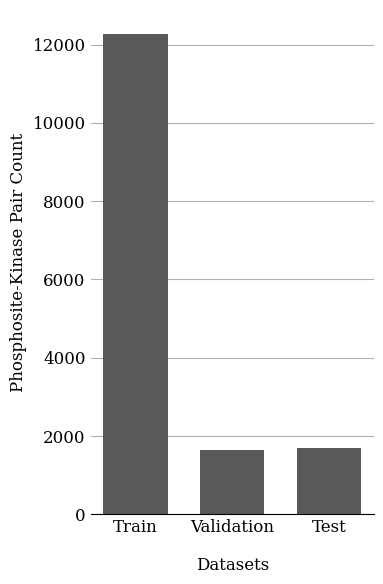

In [19]:
get_phosphosite_kinase_pair_distribution()

## 4. Phosphosite-Kinase Count Histogram of Kinases

This histogram shows how many phosphosite-kinase count is associated with how many kinases in the train, validation and test sets. 

### Function

In [20]:
'''
####################################
### Function Description:
###
### This function generates a histogram that displays the distribution of kinase phosphorylation data count
### Each bar in the histogram represents the number of kinases which have that much amount of (that much 
### here refers to the x-label) phosphorylation data in the dataset. For instance, if the x-axis is
### labeled '5-10' to denote phosphorylation datacoutn in between 5-10, and the corresponding bar height is '5'
### this indicates that there are 5 kinases which have phosphorylation data record between 5-10.  
###
####################################
'''
def create_histogram_from_kinase_occurences():
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    matplotlib.rcParams['font.size'] = 10

    train_kinase_counts, validation_kinase_counts, test_kinase_counts = get_kinase_count_in_dataset()

    thresholds = create_thresholds(0, 50, 10)
    bins_train = np.zeros(len(thresholds)+2, dtype=int)
    for key, value in train_kinase_counts.items():
        for i in range(0, len(bins_train)-2):
            end_threshold = thresholds[i]
            if value <= end_threshold:
                bins_train[i+1] += 1
                break
            if i == len(bins_train)-3:
                bins_train[i+2] += 1

    bins_validation = np.zeros(len(thresholds) + 2, dtype=int)
    for key, value in validation_kinase_counts.items():
        for i in range(0, len(bins_validation) - 2):
            end_threshold = thresholds[i]
            if value <= end_threshold:
                bins_validation[i + 1] += 1
                break
            if i == len(bins_validation) - 3:
                bins_validation[i + 2] += 1

    bins_test = np.zeros(len(thresholds) + 2, dtype=int)
    for key, value in test_kinase_counts.items():
        for i in range(0, len(bins_test) - 2):
            end_threshold = thresholds[i]
            if value <= end_threshold:
                bins_test[i + 1] += 1
                break
            if i == len(bins_test) - 3:
                bins_test[i + 2] += 1

    max_y_value = max(max(bins_train), max(bins_validation), max(bins_test))

    thresholds.insert(0, 0)
    threshold_strings = ["0"]
    threshold_strings.extend([f'{thresholds[i]+1}-{thresholds[i + 1]}' for i in range(len(thresholds) - 1)])
    threshold_strings.append(f'>{thresholds[-1]}')

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6),
                             gridspec_kw={
                                 'width_ratios': [1, 1, 1],
                                 'height_ratios': [1],
                                 'wspace': 0.05,
                                 'hspace': 0.2})

    max_y_value += 10

    setup_axes(axes[0], bins_train, "Train Set", threshold_strings, max_y_value)
    setup_axes(axes[1], bins_validation, "Validation Set", threshold_strings, max_y_value)
    setup_axes(axes[2], bins_test, "Test Set", threshold_strings, max_y_value)

    axes[0].set_ylim(0, max_y_value)
    axes[1].set_ylim(0, max_y_value)
    axes[2].set_ylim(0, max_y_value)
    for ax in axes[1:]:
        ax.set_yticklabels([])
        ax.set_ylabel("", fontweight='bold')
        # ax.set_yticks([])

    axes[1].set_xlabel("Phosphosite-kinase count", fontweight='bold', labelpad=7)

    # plt.subplots_adjust(wspace=0.5)  # Adjust the value as needed
    # fig.text(0.5, 0.1, 'Number of Phosphorylation Sites', ha='center', va='center', fontweight='bold', fontsize=12)

    plt.subplots_adjust(bottom=0.2)  # Increase the bottom parameter as needed

    # plt.tight_layout()  # Adjust layout
    # plt.show()
    # If you want to save the images, comment plt.show() and uncomment the two following lines:
    plt.savefig(f'{dataset_statistics_directory}/Kinase_Occurrenes_Histogram.pdf', format='pdf', bbox_inches='tight', dpi=350)
    plt.savefig(f'{dataset_statistics_directory}/Kinase_Occurrenes_Histogram.png', format='png', bbox_inches='tight', dpi=350)  # You can increase dpi if needed


### Function Call

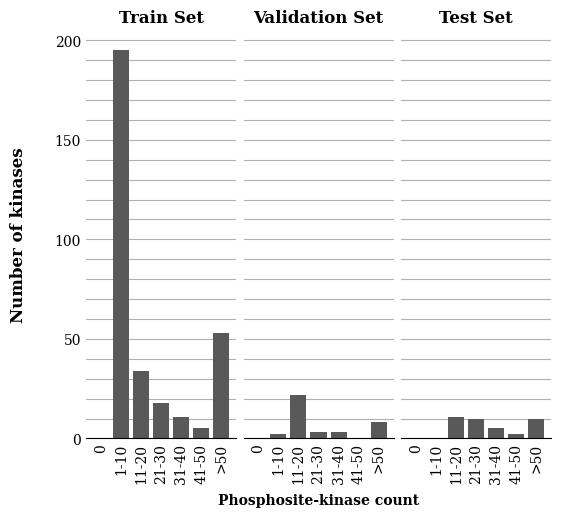

In [21]:
create_histogram_from_kinase_occurences()

## 5. Multilabel Phosphosites vs Single Kiase Phosphosites

A single phosphosite could be phosphorylated by several kinases. A phosphosite which is associated with several kinases is named as multilabel phosphosite/site, and a phosphosite which is phosphorylated by a single kinase is named as single kinase phosphosite. This plot illustrates the number of multilabel and single kinase phosphosites in the train, validation and test set.

### Function

In [40]:
'''
#########################################################################################
### Function Description:
###
### We define a site as multilabel if this site is phosphorylated by several kinases, and 
### non-multilabel if it is phosphorylated by a single kinase.
###
### This function plots the number of non-multilabel and the multilabel sites and
### in each dataset. 
#########################################################################################
'''
def get_multilabel_rows_distribution():
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    matplotlib.rcParams['font.size'] = 12

    train_rows = get_train_rows()
    validation_rows = get_validation_rows()
    test_rows = get_test_rows()

    train_site_to_kinase_count = get_site_to_kinase_count(train_rows)
    validation_site_to_kinase_count = get_site_to_kinase_count(validation_rows)
    test_site_to_kinase_count = get_site_to_kinase_count(test_rows)

    train_multilabel_rows = {k : v for k, v in train_site_to_kinase_count.items() if v > 1}
    train_nonmultilabel_rows = {k : v for k, v in train_site_to_kinase_count.items() if v == 1}

    validation_multilabel_rows = {k: v for k, v in validation_site_to_kinase_count.items() if v > 1}
    validation_nonmultilabel_rows = {k: v for k, v in validation_site_to_kinase_count.items() if v == 1}

    test_multilabel_rows = {k: v for k, v in test_site_to_kinase_count.items() if v > 1}
    test_nonmultilabel_rows = {k: v for k, v in test_site_to_kinase_count.items() if v == 1}

    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1
    font_size = 10

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6),
                             gridspec_kw={
                                 'width_ratios': [1, 1, 1],
                                 'wspace': 0.3,
                                 'hspace': 1})

    plt.rcParams['font.size'] = font_size
    pad = 10  # in points
    cols = ["Train set", "Validation set", "Test set"]
    for col in range(len(cols)):
        axes[col].annotate(cols[col], xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    x_labels_site = ["Single\nKinase\nPhosphosites", "Multiple\nKinase\nPhosphosites"]

    # first for train
    train_x_values_site = [len(train_nonmultilabel_rows), len(train_multilabel_rows)]
    validation_x_values_site = [len(validation_nonmultilabel_rows), len(validation_multilabel_rows)]
    test_x_values_site = [len(test_nonmultilabel_rows), len(test_multilabel_rows)]

    max_y_value = max(max(train_x_values_site), max(validation_x_values_site), max(test_x_values_site))

    fill_in_subplot_for__get_multilabel_rows_distribution(axes, 0, train_nonmultilabel_rows, train_multilabel_rows,
                                                          x_labels_site, train_x_values_site, "train", font_size, max_y_value)


    fill_in_subplot_for__get_multilabel_rows_distribution(axes, 1, train_nonmultilabel_rows, train_multilabel_rows,
                                                          x_labels_site, validation_x_values_site, "validation", font_size, max_y_value)

    fill_in_subplot_for__get_multilabel_rows_distribution(axes, 2, train_nonmultilabel_rows, train_multilabel_rows,
                                                          x_labels_site, test_x_values_site, "test", font_size, max_y_value)

    plt.subplots_adjust(bottom=0.2)  # Increase the bottom parameter as needed

    # plt.tight_layout()  # Adjust layout
    plt.show()
    # If you want to save the images, comment plt.show() and uncomment the two following lines:
    # plt.savefig(f'{dataset_statistics_directory}/Multilabel_vs_NonMultilabel_Rows_Distribution.pdf', format='pdf', bbox_inches='tight', dpi=350)
    # plt.savefig(f'{dataset_statistics_directory}/Multilabel_vs_NonMultilabel_Rows_Distribution.png', format='png', bbox_inches='tight', dpi=350)  # You can increase dpi if needed


### Function Call

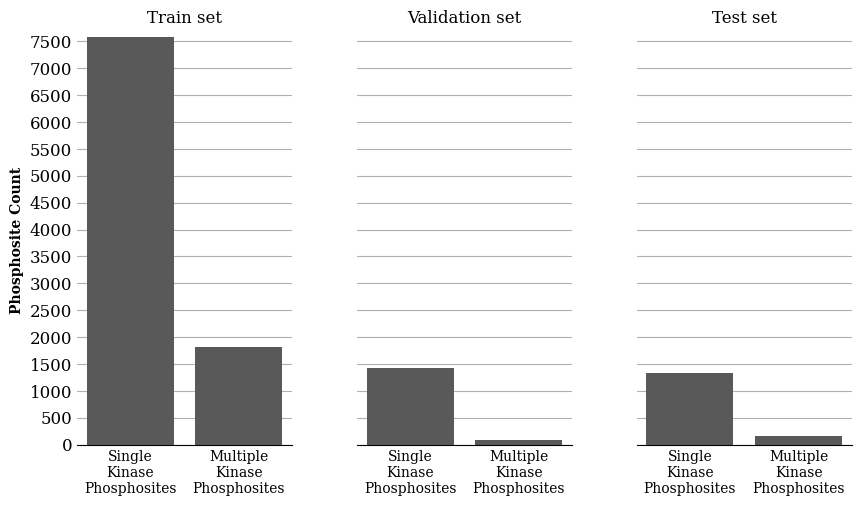

In [41]:
get_multilabel_rows_distribution()

## 6. Novel Site vs Common Site in Test

A phosphosite could be phosphorylated by several kinases, thus a phosphosite could appear in different sets. We call sites which only appear in a single set such as train, validation or test set as novel sites. Likewise we call phosphosites which appear in several sets as common sites between those sets. In this plot we report the number of novel sites in the test set, and the number of common sites with the train and validation sets.

### Function

In [42]:
def get_novel_site_vs_common_site_distribution_for_test():
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    matplotlib.rcParams['font.size'] = 12

    train_rows = get_train_rows()
    validation_rows = get_validation_rows()
    test_rows = get_test_rows()

    site_counts_in_train = get_site_to_kinase_count(train_rows)
    site_counts_in_validation = get_site_to_kinase_count(validation_rows)
    site_counts_in_test = get_site_to_kinase_count(test_rows)

    sites_in_train, sites_in_validation, sites_in_test = set(site_counts_in_train.keys()), set(site_counts_in_validation.keys()), set(site_counts_in_test.keys())

    # for test
    test_sites_common_with_train = sites_in_test.intersection(sites_in_train)
    test_sites_common_with_validation = sites_in_test.intersection(sites_in_validation)
    test_only_sites = sites_in_test - sites_in_train.union(sites_in_validation)

    ################################   TEST

    test_count_of_common_site_rows_in_test_and_train = {kinase: 0 for kinase in test_sites_common_with_train}
    for k, v in site_counts_in_test.items():
        if k in test_sites_common_with_train:
            test_count_of_common_site_rows_in_test_and_train[k] += v

    test_count_of_common_site_rows_in_test_and_validation = {kinase: 0 for kinase in test_sites_common_with_validation}
    for k, v in site_counts_in_test.items():
        if k in test_sites_common_with_validation:
            test_count_of_common_site_rows_in_test_and_validation[k] += v

    test_count_of_test_only_sites = {kinase: 0 for kinase in test_only_sites}
    for k, v in site_counts_in_test.items():
        if k in test_only_sites:
            test_count_of_test_only_sites[k] += v

    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1
    font_size = 10

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6),
                             gridspec_kw={
                                 'width_ratios': [1, 1],
                                 'height_ratios': [1],
                                 'wspace': 0.4,
                                 'hspace': 0.2})

    plt.rcParams['font.size'] = font_size
    fig.suptitle('Novel vs Common Phosphosite in the Test Dataset', fontsize=font_size + 2)  # Add a title to the figure

    # finally for test
    x_labels_site = ["Novel\nPhosphosites", "Common\nPhosphosites\nwith\nTrain", "Common\nPhosphosites\nwith\nValidation"]
    x_values_site = [len(test_only_sites), len(test_sites_common_with_train), len(test_sites_common_with_validation)]
    x_values_count_site = [sum(test_count_of_test_only_sites.values()),
                           sum(test_count_of_common_site_rows_in_test_and_train.values()),
                           sum(test_count_of_common_site_rows_in_test_and_validation.values())]
    fill_in_subplot_for__get_novel_site_vs_common_site_distribution_for_test(axes, font_size, x_labels_site, x_values_count_site, x_values_site)

    plt.subplots_adjust(bottom=0.2)  # Increase the bottom parameter as needed

    # tight_layout()  # Adjust layout
    plt.show()
    # If you want to save the images, comment plt.show() and uncomment the two following lines:
    # plt.savefig(f'{dataset_statistics_directory}/Novel_Sites_vs_Common_Sites_in_test.pdf', format='pdf', bbox_inches='tight', dpi=350)
    # plt.savefig(f'{dataset_statistics_directory}/Novel_Sites_vs_Common_Sites_in_test.png', format='png', bbox_inches='tight', dpi=350)  # You can increase dpi if needed


### Function Call

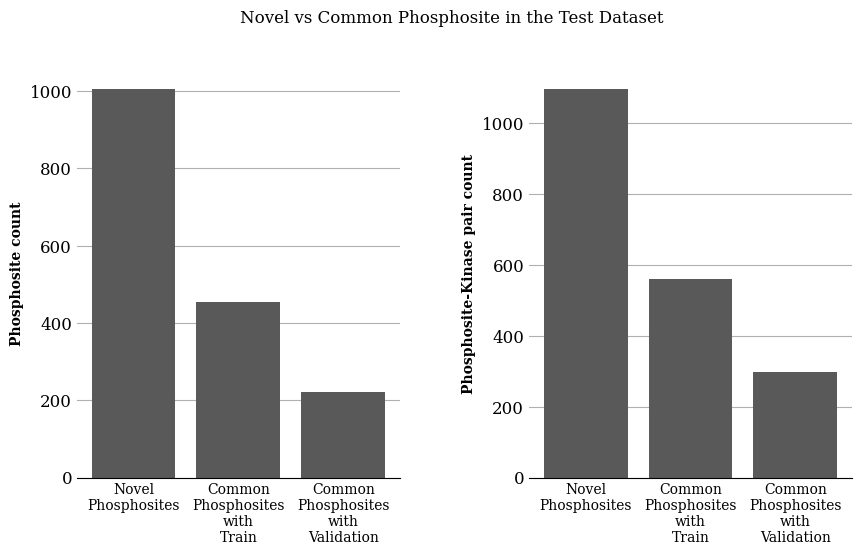

In [29]:
get_novel_site_vs_common_site_distribution_for_test()

## 7. Novel Site vs Common Site in Each Set

In this plot we show the number of novel and common sites for each set (First row). Furthermore we also show the number of phosphosite-kinase data point association corresponding to these kinases (Second row).

### Function

In [30]:
'''
###################################################################################
### Function Description:
###
### This function plots the number of common sites and the number of total phosphorylation
### data these sites correspond to, between different datasets.
### 
### E.g. first we have these:
### |# of sites which only exist in train|# of common sites in train and validation|# of common sites in train and test|
### |# of sites which only exist in validation|# of common sites in validation and train|# of common sites in validation and test|
### |# of sites which only exist in test|# of common sites in test and train|# of common sites in test and validation|
### 
### Then we have the number of phosphorylation data these sum up to. For example:
### Site1 --> kinase1, kinase2
### 
### If Site1 is a site unique to train, in other words if theis site only exists in the train dataset, 
### then this site will correspond to 2 phoshprylation data in the train dataset (site1 --> kinase1 and 
### site1 --> kinase2). So in the second plots, we will count how many phosphorylation data these sites
### correpsond to. 
###################################################################################
'''
def get_novel_site_vs_common_site_distribution():
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    matplotlib.rcParams['font.size'] = 12

    train_rows = get_train_rows()
    validation_rows = get_validation_rows()
    test_rows = get_test_rows()

    site_counts_in_train = get_site_to_kinase_count(train_rows)
    site_counts_in_validation = get_site_to_kinase_count(validation_rows)
    site_counts_in_test = get_site_to_kinase_count(test_rows)

    sites_in_train, sites_in_validation, sites_in_test = set(site_counts_in_train.keys()), set(site_counts_in_validation.keys()), set(site_counts_in_test.keys())

    # for train
    train_sites_common_with_validation = sites_in_train.intersection(sites_in_validation)
    train_sites_common_with_test = sites_in_train.intersection(sites_in_test)
    train_only_sites = sites_in_train - sites_in_validation.union(sites_in_test)

    # for validation
    validation_sites_common_with_train = sites_in_validation.intersection(sites_in_train)
    validation_sites_common_with_test = sites_in_validation.intersection(sites_in_test)
    validation_only_sites = sites_in_validation - sites_in_train.union(sites_in_test)

    # for test
    test_sites_common_with_train = sites_in_test.intersection(sites_in_train)
    test_sites_common_with_validation = sites_in_test.intersection(sites_in_validation)
    test_only_sites = sites_in_test - sites_in_train.union(sites_in_validation)

    ################################   TRAIN

    train_count_of_common_site_rows_in_train_and_valiadation = {kinase : 0 for kinase in train_sites_common_with_validation}
    for k, v in site_counts_in_train.items():
        if k in train_sites_common_with_validation:
            train_count_of_common_site_rows_in_train_and_valiadation[k] += v

    train_count_of_common_site_rows_in_train_and_test = {kinase: 0 for kinase in train_sites_common_with_test}
    for k, v in site_counts_in_train.items():
        if k in train_sites_common_with_test:
            train_count_of_common_site_rows_in_train_and_test[k] += v

    train_count_of_train_only_sites = {kinase: 0 for kinase in train_only_sites}
    for k, v in site_counts_in_train.items():
        if k in train_only_sites:
            train_count_of_train_only_sites[k] += v

    ################################   VALIDATION

    validation_count_of_common_site_rows_in_validation_and_train = {kinase: 0 for kinase in validation_sites_common_with_train}
    for k, v in site_counts_in_validation.items():
        if k in validation_sites_common_with_train:
            validation_count_of_common_site_rows_in_validation_and_train[k] += v

    validation_count_of_common_site_rows_in_validation_and_test = {kinase: 0 for kinase in validation_sites_common_with_test}
    for k, v in site_counts_in_validation.items():
        if k in validation_sites_common_with_test:
            validation_count_of_common_site_rows_in_validation_and_test[k] += v

    validation_count_of_validation_only_sites = {kinase: 0 for kinase in validation_only_sites}
    for k, v in site_counts_in_validation.items():
        if k in validation_only_sites:
            validation_count_of_validation_only_sites[k] += v

    ################################   TEST

    test_count_of_common_site_rows_in_test_and_train = {kinase: 0 for kinase in test_sites_common_with_train}
    for k, v in site_counts_in_test.items():
        if k in test_sites_common_with_train:
            test_count_of_common_site_rows_in_test_and_train[k] += v

    test_count_of_common_site_rows_in_test_and_validation = {kinase: 0 for kinase in test_sites_common_with_validation}
    for k, v in site_counts_in_test.items():
        if k in test_sites_common_with_validation:
            test_count_of_common_site_rows_in_test_and_validation[k] += v

    test_count_of_test_only_sites = {kinase: 0 for kinase in test_only_sites}
    for k, v in site_counts_in_test.items():
        if k in test_only_sites:
            test_count_of_test_only_sites[k] += v

    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1
    font_size = 10

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6.5),
                            gridspec_kw={
                                'width_ratios': [1, 1, 1],
                                'height_ratios': [10, 10],
                                'wspace': 0.2,
                                'hspace': 1})

    plt.rcParams['font.size'] = font_size
    pad = 5  # in points
    cols = ["Train set", "Validation set", "Test set"]
    for ax, col in zip(axes[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    # first for train
    x_labels_site = ["train only sites", "common sites with validation", "common sites with test"]
    x_values_site = [len(train_only_sites), len(train_sites_common_with_validation), len(train_sites_common_with_test)]
    x_values_count_site = [sum(train_count_of_train_only_sites.values()), sum(train_count_of_common_site_rows_in_train_and_valiadation.values()), sum(train_count_of_common_site_rows_in_train_and_test.values())]
    fill_in_subplot_for__get_novel_site_vs_common_site_distribution(axes, 0, font_size, x_labels_site,
                                                                    x_values_count_site, x_values_site)

    # then for validation
    x_labels_site = ["validation only sites", "common sites with train", "common sites with test"]
    x_values_site = [len(validation_only_sites), len(validation_sites_common_with_train), len(validation_sites_common_with_test)]
    x_values_count_site = [sum(validation_count_of_validation_only_sites.values()), sum(validation_count_of_common_site_rows_in_validation_and_train.values()), sum(validation_count_of_common_site_rows_in_validation_and_test.values())]
    fill_in_subplot_for__get_novel_site_vs_common_site_distribution(axes, 1, font_size, x_labels_site,
                                                                   x_values_count_site, x_values_site)


    # finally for test
    x_labels_site = ["test only sites", "common sites with train", "common sites with validation"]
    x_values_site = [len(test_only_sites), len(test_sites_common_with_train), len(test_sites_common_with_validation)]
    x_values_count_site = [sum(test_count_of_test_only_sites.values()),
                           sum(test_count_of_common_site_rows_in_test_and_train.values()),
                           sum(test_count_of_common_site_rows_in_test_and_validation.values())]
    fill_in_subplot_for__get_novel_site_vs_common_site_distribution(axes, 2, font_size, x_labels_site, x_values_count_site, x_values_site)

    # plt.tight_layout()  # Adjust layout
    plt.show()
    # If you want to save the images, comment plt.show() and uncomment the two following lines:
    # plt.savefig(f'{dataset_statistics_directory}/Novel_Sites_vs_Common_Sites.pdf', format='pdf', bbox_inches='tight', dpi=350)
    # plt.savefig(f'{dataset_statistics_directory}/Novel_Sites_vs_Common_Sites.png', format='png', bbox_inches='tight', dpi=350)  # You can increase dpi if needed


### Function Call

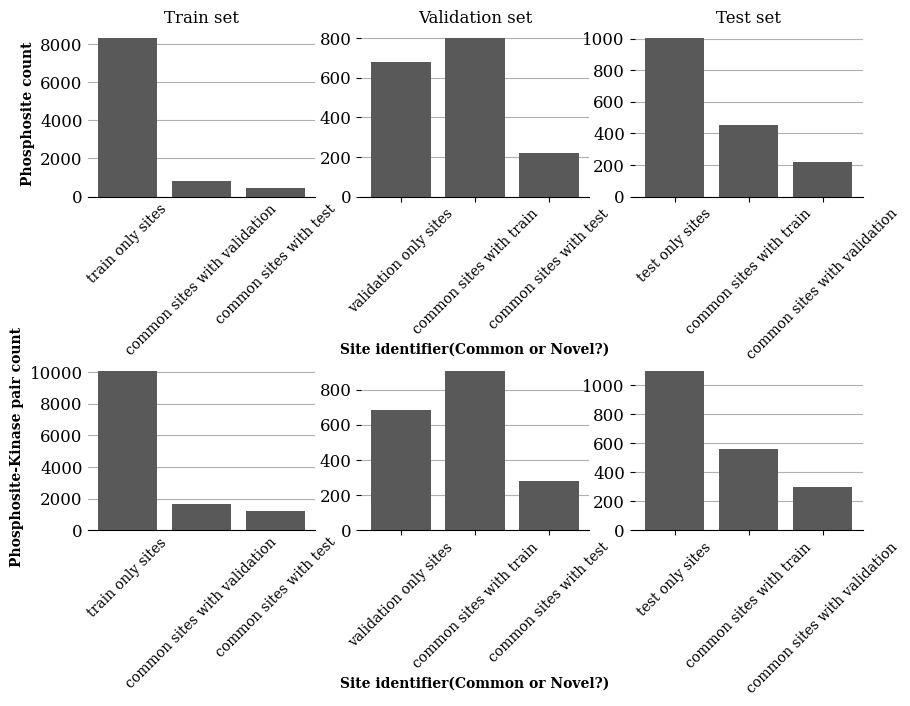

In [31]:
get_novel_site_vs_common_site_distribution()

## 8. Phosphosite Kinase Association Histogram of Kinases

In this plot, we show the number of phosphosites associated with the number of kinases specified in the x label. 

### Function

In [43]:
'''
####################################
### Function Description:
###
### We define a site as multilabel if this site is phosphorylated by several kinases, and 
### non-multilabel if it is phosphorylated by a single kinase.
###
### This function generates a histogram that displays the distribution of phosphorylation sites based on
### the count of kinases that target them. Each bar in the histogram represents the number of phosphorylation
### sites that are phosphorylated by a specific number of kinases. For instance, if the x-axis is labeled
### '10' to denote 10 kinases, and the corresponding bar height is '5', it indicates that there are 5
### distinct phosphorylation sites in the dataset that are each phosphorylated by 10 different kinases.
###
####################################
'''
def get_multilabel_rows_distribution_histogram():
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['font.family'] = 'DeJavu Serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    matplotlib.rcParams['font.size'] = 12

    train_rows = get_train_rows()
    validation_rows = get_validation_rows()
    test_rows = get_test_rows()

    train_site_to_kinase_count = get_site_to_kinase_count(train_rows)
    validation_site_to_kinase_count = get_site_to_kinase_count(validation_rows)
    test_site_to_kinase_count = get_site_to_kinase_count(test_rows)

    largest_shared_site = max(max(train_site_to_kinase_count.values()), max(validation_site_to_kinase_count.values()), max(test_site_to_kinase_count.values()))
    thresholds = create_thresholds(1, largest_shared_site+1, 1)
    bins_train = np.zeros(len(thresholds), dtype=int)
    for key, value in train_site_to_kinase_count.items():
        bins_train[value-1] += 1

    bins_validation = np.zeros(len(thresholds), dtype=int)
    for key, value in validation_site_to_kinase_count.items():
        bins_validation[value - 1] += 1

    bins_test = np.zeros(len(thresholds), dtype=int)
    for key, value in test_site_to_kinase_count.items():
        bins_test[value - 1] += 1

    threshold_strings = [f'{i}' for i in range(1, len(thresholds)+1)]

    font_size = 10

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6),
                             gridspec_kw={
                                 'width_ratios': [1, 1, 1],
                                 'height_ratios': [1],
                                 'wspace': 0.2,
                                 'hspace': 1})

    plt.rcParams['font.size'] = font_size
    pad = 3  # in points
    cols = ["Train set", "Validation set", "Test set"]
    for ax, col in zip(axes, cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    x_labels_site, train_x_values_site = threshold_strings, bins_train
    x_labels_site, validation_x_values_site = threshold_strings, bins_validation
    x_labels_site, test_x_values_site = threshold_strings, bins_test

    max_y_value = max(max(train_x_values_site), max(validation_x_values_site), max(test_x_values_site))

    fill_in_subplots_for__get_multilabel_rows_distribution_histogram(axes, 0, x_labels_site, train_x_values_site,
                                                                     font_size, max_y_value)

    fill_in_subplots_for__get_multilabel_rows_distribution_histogram(axes, 1, x_labels_site, validation_x_values_site,
                                                                     font_size, max_y_value)

    fill_in_subplots_for__get_multilabel_rows_distribution_histogram(axes, 2, x_labels_site, test_x_values_site,
                                                                     font_size, max_y_value)

    plt.subplots_adjust(bottom=0.2)  # Increase the bottom parameter as needed
    # plt.tight_layout()  # Adjust layout
    plt.show()
    # If you want to save the images, comment plt.show() and uncomment the two following lines:
    # plt.savefig(f'{dataset_statistics_directory}/Multilabel_Rows_Histogram.pdf', format='pdf', bbox_inches='tight', dpi=350)
    # plt.savefig(f'{dataset_statistics_directory}/Multilabel_Rows_Histogram.png', format='png', bbox_inches='tight', dpi=350)  # You can increase dpi if needed


### Function Call

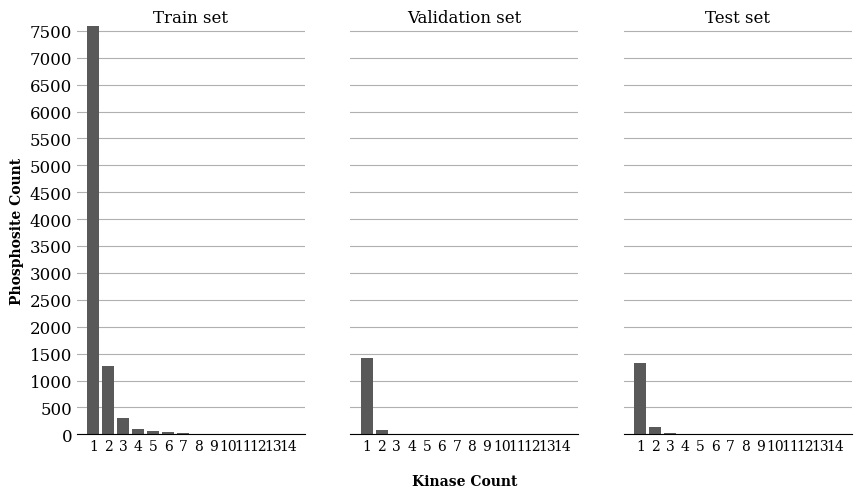

In [33]:
get_multilabel_rows_distribution_histogram()

## 9. Kinase Group Distribution

This plot illustrates the number of kinases from each group for that specific set (First row). Furthermore it also illustrates the number of phosphosite-kinase association data points these kinases correspond to in that specific set (second row).

### Function

In [34]:
'''
####################################
### Function Description:
###
### Each kinase belongs to a specified 'Group' which is in general decided according to the amino acid sequence
### of this kinase. 
###  
### This function plots the distribution of the groups of the kinases in each dataset. 
### It also plots the number of site which correspond to in that dataset. Thus, the plots
### with the data counts show the number of sites in that group. The logic that is used is like the following:
### site1 --> kinase1(Group1), kinase2(Group1), kinase3(Group2)
### site2 --> kinase1(Group1), kinase2(Group2), kinase3(Group3)
### 
### In this case Group1 will have 2 sites, and Group2 will have 2 sites, Groups3 will have 1 site.
### Even though site1 has kinase1(Group1) and kinase2(Group1), since both kinases are from Group1
### and since we are counting the sites, this will be ounted as a single site inside Group1. 
### 
####################################
'''
def get_kinase_group_distributions_with_site_count_information():
    train_rows = get_train_rows()
    validation_rows = get_validation_rows()
    test_rows = get_test_rows()

    _, uniprots_to_groups = map_family_group_info()
    kinase_groups = list(set(uniprots_to_groups.values()))
    kinase_groups.sort()

    train_group_distribution = {group: set() for group in kinase_groups}
    train_group_count_distribution = {group: set() for group in kinase_groups}
    validation_group_distribution = {group: set() for group in kinase_groups}
    validation_group_count_distribution = {group: set() for group in kinase_groups}
    test_group_distribution = {group: set() for group in kinase_groups}
    test_group_count_distribution = {group: set() for group in kinase_groups}

    for row in train_rows:
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        site_identifier = f'{row["SUB_ACC_ID"]}|{row["SUB_MOD_RSD"]}|{row["SITE_+/-7_AA"]}'
        site_to_group = set()
        for kinase in kinases:
            group = uniprots_to_groups[kinase]
            train_group_distribution[group].add(kinase)
            site_to_group.add(group)
        for group in site_to_group:
            train_group_count_distribution[group].add(site_identifier)

    for row in validation_rows:
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        site_to_group = set()
        site_identifier = f'{row["SUB_ACC_ID"]}|{row["SUB_MOD_RSD"]}|{row["SITE_+/-7_AA"]}'
        for kinase in kinases:
            group = uniprots_to_groups[kinase]
            validation_group_distribution[group].add(kinase)
            site_to_group.add(group)
        for group in site_to_group:
            validation_group_count_distribution[group].add(site_identifier)

    for row in test_rows:
        kinases = row["KINASE_ACC_IDS"]
        kinases = set(kinases.split(','))
        site_to_group = set()
        site_identifier = f'{row["SUB_ACC_ID"]}|{row["SUB_MOD_RSD"]}|{row["SITE_+/-7_AA"]}'
        for kinase in kinases:
            group = uniprots_to_groups[kinase]
            test_group_distribution[group].add(kinase)
            site_to_group.add(group)
        for group in site_to_group:
            test_group_count_distribution[group].add(site_identifier)

    grayish_color = (0.35, 0.35, 0.35)  # RGB values range from 0 to 1
    font_size = 7

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6),
                             gridspec_kw={
                                 'width_ratios': [1, 1, 1],
                                 'height_ratios': [0.2, 10, 10],
                                 'wspace': 0.4,
                                 'hspace': 1})

    plt.rcParams['font.size'] = font_size
    pad = 3  # in points
    cols = ["Train set", "Validation set", "Test set"]
    for ax, col in zip(axes[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    # first for train
    x_labels_kinase_group = []
    x_values_kinase_group = []
    for k, v in train_group_distribution.items():
        x_labels_kinase_group.append(k)
        x_values_kinase_group.append(len(v))

    x_labels_kinase_count_group = []
    x_values_kinase_count_group = []
    for k, v in train_group_count_distribution.items():
        x_labels_kinase_count_group.append(k)
        x_values_kinase_count_group.append(len(v))

    unique_sites = set()
    for group, site_set in train_group_count_distribution.items():
        unique_sites = unique_sites.union(site_set)

    fill_in_subplots_for__get_kinase_group_distributions_with_site_count_information(axes, 0,
                                                                                     x_values_kinase_group,
                                                                                     unique_sites,
                                                                                     x_labels_kinase_group,
                                                                                     x_labels_kinase_count_group,
                                                                                     x_values_kinase_count_group,
                                                                                     font_size)

    # Then for test
    x_labels_kinase_group = []
    x_values_kinase_group = []
    for k, v in validation_group_distribution.items():
        x_labels_kinase_group.append(k)
        x_values_kinase_group.append(len(v))

    x_labels_kinase_count_group = []
    x_values_kinase_count_group = []
    for k, v in validation_group_count_distribution.items():
        x_labels_kinase_count_group.append(k)
        x_values_kinase_count_group.append(len(v))

    unique_sites = set()
    for group, site_set in validation_group_count_distribution.items():
        unique_sites = unique_sites.union(site_set)

    fill_in_subplots_for__get_kinase_group_distributions_with_site_count_information(axes, 1,
                                                                                     x_values_kinase_group,
                                                                                     unique_sites,
                                                                                     x_labels_kinase_group,
                                                                                     x_labels_kinase_count_group,
                                                                                     x_values_kinase_count_group,
                                                                                     font_size)

    # Then for test
    x_labels_kinase_group = []
    x_values_kinase_group = []
    for k, v in test_group_distribution.items():
        x_labels_kinase_group.append(k)
        x_values_kinase_group.append(len(v))

    x_labels_kinase_count_group = []
    x_values_kinase_count_group = []
    for k, v in test_group_count_distribution.items():
        x_labels_kinase_count_group.append(k)
        x_values_kinase_count_group.append(len(v))

    unique_sites = set()
    for group, site_set in test_group_count_distribution.items():
        unique_sites = unique_sites.union(site_set)

    fill_in_subplots_for__get_kinase_group_distributions_with_site_count_information(axes, 2,
                                                                                     x_values_kinase_group,
                                                                                     unique_sites,
                                                                                     x_labels_kinase_group,
                                                                                     x_labels_kinase_count_group,
                                                                                     x_values_kinase_count_group,
                                                                                     font_size)

    # plt.tight_layout()  # Adjust layout
    plt.show()
    # If you want to save the images, comment plt.show() and uncomment the two following lines:
    # plt.savefig(f'{dataset_statistics_directory}/Kinase_Group_Distribution_and_Site_Count.pdf', format='pdf', bbox_inches='tight', dpi=350)
    # plt.savefig(f'{dataset_statistics_directory}/Kinase_Group_Distribution_and_Site_Count.png', format='png', bbox_inches='tight', dpi=350)  # You can increase dpi if needed


### Function Call

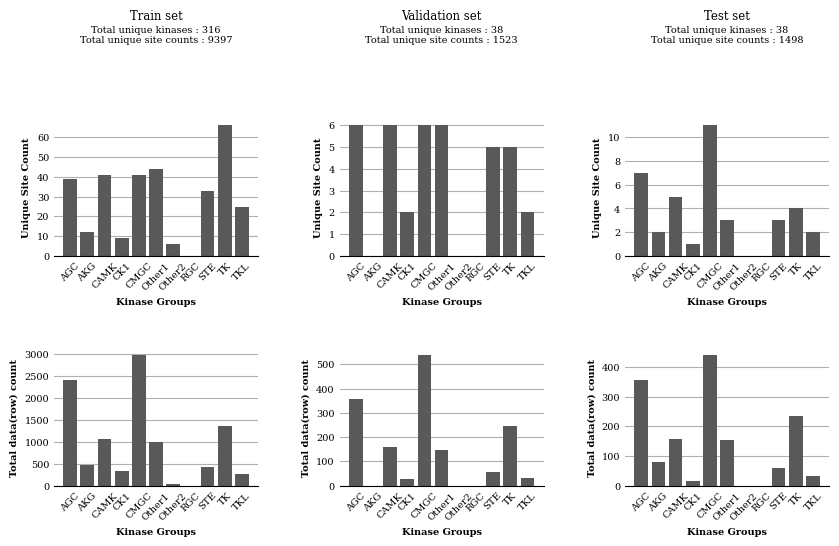

In [36]:
get_kinase_group_distributions_with_site_count_information()